# Exploring the Dimension K of a Partial Order

This notebook illustrates:
1. **Definition** of partial‐order dimension and its relationship to $k$.
2. Why $dim(h)$ reflects complexity.
3. How changing $K$ above $dim(h)$ doesn't alter the partial order.
4. Basic functions for partial‐order critical orders and realizer construction.
5. Demonstration on the *crown poset* to show $dim(h) = n/2$
6. Perform the MCMC for $dim(h)$ and also its posterior distribution for $K$

Refernce:
W. T. Trotter, Combinatorics and Partially Ordered Sets: Dimension Theory, (Johns Hopkins Univ. Press, 1992).
This monograph is a central text for the theory of dimension, realisers, and critical pairs.
It gives rigorous definitions of “critical pairs,” discusses minimal (critical) subposets that witness dimension, and includes proofs about how realisers must separate those pairs.

## 1. Definition of Dimension

We say a partial order $h = (X, \prec_h)$ has **dimension** $K$ if there exist $K$ total orders $\ell_1, \dots, \ell_K$ such that:

$x \prec_h y \quad \Longleftrightarrow \quad (x <_{\ell_k} y \text{ for each } k = 1, \dots, K)$.

If $\dim(h) = K$, then any $K+1$ columns (i.e., total orders) will still intersect to the same partial order as long as they don't introduce new forced edges. 

Essentially, **once the minimal $K$ is reached, adding more linear extensions won't change the partial order** as long as those additional extensions are "consistent."

Below, we'll show how this works in code by enumerating linear extensions and checking dimension on small examples.


In [1]:
import sys
import os

# Get the absolute path to the project root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, project_root)  # Add project root to Python path

# Import custom modules
from src.utils.basic_utils import BasicUtils
from src.utils.statistical_utils import StatisticalUtils
from src.utils.generation_utils import GenerationUtils
from src.visualization.po_plot import POPlot
from src.mcmc.likelihood_cache import LogLikelihoodCache
from src.mcmc.mcmc_simulation import mcmc_partial_order
from src.mcmc.mcmc_simulation_k import mcmc_partial_order_k
# Import necessary libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz as pgv
from typing import List, Dict, Any
import seaborn as sns 
from scipy.stats import beta
import itertools
from math import inf

# Load configuration
import yaml
config_path = os.path.join(project_root, 'config', 'mcmc_config.yaml')
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

## 2. Dimension Property Exploration

### Critical Pairs
A critical pair $(x,y)$ in a poset $P$ is an incomparable pair that, once forced into a certain order ($x \prec y$), induces further transitive orderings. Informally, each linear extension can only “resolve” some subset of these critical pairs, and one typically needs enough linear orders to cover such pairs.

In [2]:
# first to find the critical paris 
def find_critical_pairs(elements, adj):
    """
    Return all incomparable pairs (x,y), x<y lexicographically, 
    that are not in the transitive closure.
    """
    tc = BasicUtils.transitive_closure(adj)
    pairs = []
    n = len(elements)
    for i in range(n):
        for j in range(i+1, n):
            # If neither i -> j nor j -> i is in the closure, they are incomparable.
            if tc[i, j] == 0 and tc[j, i] == 0:
                pairs.append((elements[i], elements[j]))
    return pairs

### Realizer Definition
A realizer for a poset $h = (X, \prec)$ is a family of linear extensions $\{\ell_1, \dots, \ell_K\}$ such that:
$ h = \bigcap_{i=1}^K \ell_i.$

Equivalently, each pair $(x, y)$ that is not comparable in $h$ must be "flipped" in at least one extension, so that $y < x$ in that extension. Consequently, if $x$ and $y$ are incomparable, there must exist some $\ell_i$ where $y <_{\ell_i} x$.


In [3]:

def realizer_to_partial_order_matrix(realizer, items=None):
    """
    Generate a partial order matrix from a collection of linear extensions.
    
    Parameters:
        realizer: A collection of linear extensions (each is a list/tuple of items).
        items: Optional list of items. If not provided, items are extracted from the realizer.
        
    Returns:
        H: an n x n numpy array such that H[i,j] = 1 if every linear extension orders items[i] before items[j].
    """
    if items is None:
        items = sorted(set(item for ext in realizer for item in ext))
    n = len(items)
    H = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            if i != j:
                H[i, j] = 1 if all(ext.index(items[i]) < ext.index(items[j]) for ext in realizer) else 0
    return H

def find_min_realizer_brute_optimized(h, items):
    """
    Optimized search for a minimal realizer for a given partial order matrix.
    
    Instead of repeatedly computing the intersection by looping over items,
    this version precomputes each extension's matrix and then uses vectorized
    logical AND to combine them.
    
    Parameters:
        h: The target partial order as an n x n numpy array.
        items: List of items corresponding to the rows/columns of h.
    
    Returns:
        A tuple (best_subset, best_size) where best_subset is a tuple of linear extensions
        whose intersection equals h (after taking transitive closures), and best_size is the number of extensions.
    """
    # Generate all linear extensions.
    all_exts = BasicUtils.generate_all_linear_extensions(h, items)
    
    # Precompute the matrix for each individual extension.
    # For a single extension, we can compute its matrix by passing [ext] to our function.
    matrices = [realizer_to_partial_order_matrix([ext], items) for ext in all_exts]
    
    # Compute the transitive closure of the target matrix once.
    target_tc = BasicUtils.transitive_closure(h)
    
    best_size = inf
    best_subset = None
    n_ext = len(matrices)
    
    # Iterate over combinations of indices (referring to precomputed matrices)
    for size in range(1, n_ext + 1):
        for combo in itertools.combinations(range(n_ext), size):
            # Compute the intersection matrix via elementwise logical AND.
            inter_matrix = matrices[combo[0]].copy()
            for idx in combo[1:]:
                inter_matrix = np.logical_and(inter_matrix, matrices[idx])
            inter_matrix = inter_matrix.astype(int)
            # Check if the transitive closure of the intersection equals that of the target.
            if np.array_equal(BasicUtils.transitive_closure(inter_matrix), target_tc):
                best_size = size
                best_subset = tuple(all_exts[i] for i in combo)
                break
        if best_subset is not None:
            break

    return best_subset, best_size


### 2. Why $dim(h)$ reflects complexity.

- $\dim(h)$ measures complexity. If $\dim(h)$ is large (as in a crown poset), the partial order has many incomparable pairs that each need to be “flipped” at least once.
- In a Bayesian setting, letting $K$ vary means we perform *model selection* over partial-order complexity. For data that strongly suggests a simpler partial order, the posterior on $K$ might concentrate at smaller values, and so on.


Given the same node n, under different dim(h), we plot differnt partial orders and understand the differences. Given the node n=6, we can take the K=2,3. The construcion of the partial orders are from the concept called realizers

Critical pairs (incomparable): 6
Critical pairs (incomparable): 9
Critical pairs (incomparable): 6


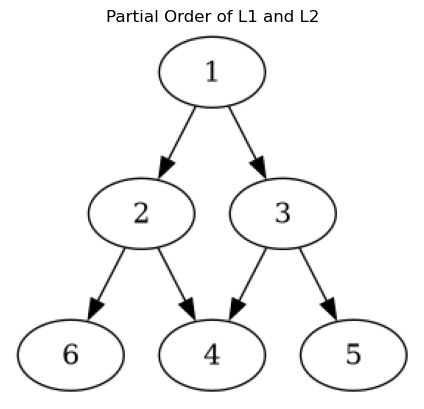

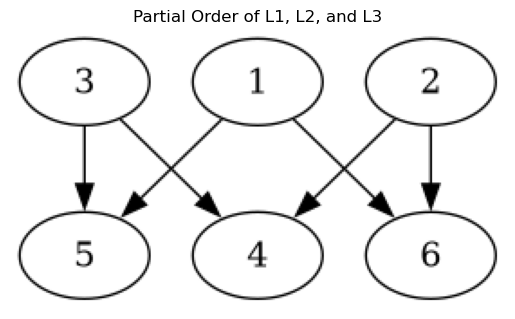

Minimal realizer size of h2 is: 2
Minimal realizer size of h3 is : 3


In [4]:
items = [str(i) for i in range(1,7)]

L1 = ["1","2","6","3","4","5"]
L2 = ["1","3","5","2","4","6"]
L3 = ["2","3","4","1","5","6"]


h2 = realizer_to_partial_order_matrix([L1, L2],items) 
h3 = realizer_to_partial_order_matrix([L1, L2, L3],items)
# h4 = realizer_to_partial_order_matrix([L1, L2, L3, L4],items)
cpairs2 = find_critical_pairs(items, h2)
cpairs3 = find_critical_pairs(items, h3)
# cpairs4 = find_critical_pairs(items, h4)
print(f"Critical pairs (incomparable): {len(cpairs2)}")
print(f"Critical pairs (incomparable): {len(cpairs3)}")
print(f"Critical pairs (incomparable): {len(cpairs2)}")
POPlot.visualize_partial_order(BasicUtils.transitive_reduction(h2), items, title="Partial Order of L1 and L2")
POPlot.visualize_partial_order(BasicUtils.transitive_reduction(h3), items, title="Partial Order of L1, L2, and L3")
# POPlot.visualize_partial_order(BasicUtils.transitive_reduction(h4), items, title="Partial Order of L1, L2, L3 and L4")

subset2, size2 =  find_min_realizer_brute_optimized(h2, items)
subset3, size3 = find_min_realizer_brute_optimized(h3, items)
# subset4, size4 =  find_min_realizer_brute_optimized(h4, items)
print(f"Minimal realizer size of h2 is: {size2}")
print(f"Minimal realizer size of h3 is : {size3}")

### 3. How changing $K$ above $dim(h)$ doesn't alter the partial order.

If we adding more linear extensions, we will always getting a PO with less dimensions, let's verify this:

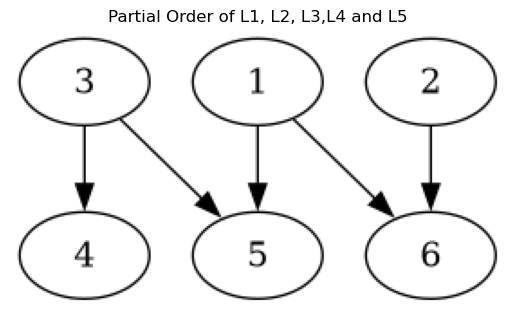

Minimal realizer size of h5 is: 2 and this is less than the previous crown partial order 3


In [5]:
### Lets add more lists for the realizer, the dimension will not exceed k. 
L4 = ["1","3","5","4","2","6"]
L5 = ["2","1","3","4","5","6"]
h5 = realizer_to_partial_order_matrix([L1, L2, L3,L4,L5],items)
POPlot.visualize_partial_order(BasicUtils.transitive_reduction(h5), items, title="Partial Order of L1, L2, L3,L4 and L5")
subset5, size5 =  find_min_realizer_brute_optimized(h2, items)
print(f"Minimal realizer size of h5 is: {size5} and this is less than the previous crown partial order {size3}")

###  4. The Complexity problem of the dimension


It is also indicated by the fact that we have no heuristics or approximation algorithms to produce realizers of partial orders that have reasonable size. 

Yannakakis (1982) establishes crucial complexity results:
- Polynomial cases: Dimension 1-2 can be determined in polynomial time, this will include the VSP 
- Remains NP-complete even for height 1 posets when $K>=4$ , height 1 is the crown poset 
- Height reduction techniques (to height 1) may help while preserving key properties


Determining the exact dimension of a general poset $h$ is an NP-hard problem. Hence, one typically resorts to:
- Brute Force (Enumerate linear extensions for small $n$, then search for the minimal covering subset).
- Critical Pair / Backtracking (Systematically cover all incomparabilities with as few linear orders as possible).


#### 4.1 Brute-Force Realizer Search

We search for the smallest set of linear extensions whose intersection reproduces the original poset h. The procedure is:

1. **Generate all linear extensions of h.**  
   This step is *extremely* expensive in the worst case—there can be up to n! extensions for n items.
2. **Convert each linear extension to its corresponding adjacency matrix.**  
   Each matrix represents the partial order implied by that linear extension.
3. **Enumerate subsets of these linear-extension matrices** in ascending order of size.  
   - Combine (intersect) the matrices within a subset via logical-AND operations.  
   - Check if the transitive closure of this combined matrix matches the original poset h.  
4. **Stop** as soon as we find the first subset whose intersection equals h.  
   This subset is necessarily of minimum size.

**Complexity Analysis**

- **Generating all linear extensions**:  
  Up to $n!$ in the worst case.  
- **Enumerating all subsets**:  
  Potentially $ 2^{n!} - 1 $ subsets if there are $n!$ linear extensions.  
- **Matrix intersection** for a subset of size $k$ and 
 $ k- 1$ logical-AND operations on an $n \times n$matrix, each taking $O(n^2)$.  
- **Transitive closure** of the combined matrix:  
  Typically $O(n^3)$ with a standard algorithm (e.g., Floyd–Warshall).  

Putting it all together, the overall worst-case complexity can be as large as:

$$
O(n!) + O\left(2 ^{ n!} \cdot \left(n^2 + n^3\right)\right)
$$

In practice, such a brute-force approach is **only feasible for very small** n or in special cases where the partial order is constrained enough to dramatically reduce the number of linear extensions.


In [6]:

def find_min_realizer_brute_optimized(h, items):
    # Generate all linear extensions.
    all_exts = BasicUtils.generate_all_linear_extensions(h, items)
    
    # Precompute the matrix for each individual extension.
    # For a single extension, we can compute its matrix by passing [ext] to our function.
    matrices = [realizer_to_partial_order_matrix([ext], items) for ext in all_exts]
    
    # Compute the transitive closure of the target matrix once.
    target_tc = BasicUtils.transitive_closure(h)
    
    best_size = inf
    best_subset = None
    n_ext = len(matrices)
    
    # Iterate over combinations of indices (referring to precomputed matrices)
    for size in range(1, n_ext + 1):
        for combo in itertools.combinations(range(n_ext), size):
            # Compute the intersection matrix via elementwise logical AND.
            inter_matrix = matrices[combo[0]].copy()
            for idx in combo[1:]:
                inter_matrix = np.logical_and(inter_matrix, matrices[idx])
            inter_matrix = inter_matrix.astype(int)
            # Check if the transitive closure of the intersection equals that of the target.
            if np.array_equal(BasicUtils.transitive_closure(inter_matrix), target_tc):
                best_size = size
                best_subset = tuple(all_exts[i] for i in combo)
                break
        if best_subset is not None:
            break

    return best_subset, best_size



#### 4.2 Critical Pair Method


1. Critical Pairs: We compute them with find_critical_pairs(items, h), identify all pairs(x,y) such that x and y are incomparable in the partial order, the worst case is $O(n^2)$.
2. Flips: We generate all linear extensions of $h$. Let $L$ be the number of these extensions. In the worst case, $L = n!$. For each extension (which is a permutation of the $n$ items), we check all $c$ critical pairs. That’s $O(c)$ work per extension, so the total cost is $O(L \cdot c)$. Storing the “flips” (i.e., which critical pairs are reversed by each extension) is also within that cost.

3. Set Cover: We only consider extension combos that collectively cover all critical pairs. If a combo fails to cover them, it can’t keep them incomparable in the final intersection. This set-cover filter typically drastically reduces the subsets we must check in detail.
4. Intersection Check: For combos that pass the set-cover test, we still confirm that the final intersection’s transitive closure equals the target partial order. We do this once per candidate subset in intersection_matches_target. We do up to $(k - 1)$ logical-AND operations on $n \times n$ matrices, each costing $O(n^2)$. So the matrix intersection cost is $O(k \cdot n^2)$.


In practice, the set-cover step often trims the search space significantly, making it feasible for small or moderately constrained posets. 


- **Worst-Case Generation of Extensions:**  
  $ L $can be as large as $n!$.

- **Worst-Case Subset Enumeration:**  
  Up to $2^L = 2^{n!}$ subsets.

- **Cost per Subset:**
  - Checking coverage: $ O(k + c)$
  - Matrix intersection: $ O(k \cdot n^2) $
  - Transitive closure: $( O(n^3) $

- **Total Raw Upper Bound (ignoring pruning):**

$$
O(n!) + O\left(2 ^{ n!} \cdot \left(n^2 + n^3\right)\right)
$$


In [7]:

def extensions_cover_critical_pairs(items, all_exts, critical_pairs):
    """
    Given:
        items: the item list (matching partial order matrix indexing).
        all_exts: a list of linear extensions (each is a list of items).
        critical_pairs: list of incomparable pairs (x,y) with x<y in items order.
    
    Returns:
        flips_list: a list of sets, one set per extension, containing the *indices* of 
                    critical pairs that are 'flipped' by that extension. 
                    If the pair is (x,y) and extension e has y < x, then 
                    e 'flips' that pair.
    
    Also returns the list of *all pair indices* that must be covered 
    if the realizer is to keep those pairs incomparable.
    """
    pair_index = {cp: i for i, cp in enumerate(critical_pairs)}  # (x,y)-> index
    
    flips_list = []
    for ext in all_exts:
        # Build a map from item->pos
        pos_map = {item: p for p, item in enumerate(ext)}
        flips = set()
        # If y < x in ext for a pair (x,y), that extension 'flips' that pair
        for cp in critical_pairs:
            x, y = cp
            if pos_map[y] < pos_map[x]:
                flips.add(pair_index[cp])
        flips_list.append(flips)
    
    all_pair_indices = set(range(len(critical_pairs)))  # 0..(#pairs-1)
    return flips_list, all_pair_indices


def intersection_matches_target(subset_idx, all_exts, items, target_tc):
    """
    Given a subset of linear extensions (via their indices subset_idx),
    compute their intersection (as a 0/1 adjacency matrix) and compare 
    its transitive closure to target_tc.
    
    Parameters:
        subset_idx: A list or tuple of extension indices from 'all_exts'.
        all_exts: The entire list of linear extensions for the poset.
        items: The item list for the poset (for indexing).
        target_tc: The transitive closure of the target partial order matrix.
    
    Returns:
        True if the intersection's transitive closure = target_tc, else False.
    """
    # Build intersection matrix via elementwise AND of each extension's matrix
    # A single extension e => we can get its 0/1 matrix by realizer_to_partial_order_matrix([e], items)
    
    # Precompute each extension's adjacency matrix:
    # (We do this outside if we want to optimize further, but let's do it inline for clarity)
    n = len(items)
    ext_matrices = []
    for e in all_exts:
        M = np.zeros((n,n), dtype=int)
        pos_map = {it: i for i, it in enumerate(e)}
        for i in range(n):
            for j in range(n):
                if i != j:
                    M[i,j] = 1 if pos_map[items[i]] < pos_map[items[j]] else 0
        ext_matrices.append(M)
    
    # Intersection is the AND of all chosen extension matrices
    inter_matrix = ext_matrices[subset_idx[0]].copy()
    for idx in subset_idx[1:]:
        inter_matrix = np.logical_and(inter_matrix, ext_matrices[idx])
    inter_matrix = inter_matrix.astype(int)
    
    # Compare transitive closures
    inter_tc = BasicUtils.transitive_closure(inter_matrix)
    return np.array_equal(inter_tc, target_tc)



def find_min_realizer_via_critical_pairs(h, items):

    n = len(items)
    target_tc = BasicUtils.transitive_closure(h)
    
    # 1) All linear extensions
    all_exts = BasicUtils.generate_all_linear_extensions(h, items)
    
    # 2) Critical pairs
    critical_pairs = find_critical_pairs(items, h)
    if not critical_pairs:
        # If no critical pairs, then h is a total order => dimension=1
        return (tuple([all_exts[0]]), 1)
    
    # 3) For each extension, record which critical pairs it flips
    flips_list, all_pair_indices = extensions_cover_critical_pairs(items, all_exts, critical_pairs)
    
    # 4) Now we do a set-cover–based approach for subsets (start from smaller to bigger)
    best_size = inf
    best_subset = None
    
    # We'll keep indices in range(len(all_exts)) to reference 'all_exts'
    L = len(all_exts)
    
    for size in range(1, L + 1):
        # Generate combos of that size
        for combo in itertools.combinations(range(L), size):
            # Union of flips in this combo
            union_flips = set()
            for idx in combo:
                union_flips |= flips_list[idx]
            # Check if all critical pairs are flipped => set cover
            if union_flips == all_pair_indices:
                # Then check intersection correctness
                if intersection_matches_target(combo, all_exts, items, target_tc):
                    best_size = size
                    best_subset = tuple(all_exts[i] for i in combo)
                    break
        if best_subset is not None:
            break
    
    return best_subset, best_size


## 3. The Crown Poset

If $n = 2k$, we partition the set into two subsets:
$A = \{a_1, \dots, a_k\}$ and $B = \{b_1, \dots, b_k\}$.

We define the partial order such that $a_i \prec b_j$ if and only if $i \neq j$.

This poset is known as the **crown poset**, and it has dimension $k$. 

We'll verify this by enumerating all linear extensions and searching for the minimal subset whose intersection reproduces the crown.


In [8]:
############################
# Section 2: Generating a Crown Poset
############################

def generate_crown_poset(k):
    """
    Return items, adj, and adj_matrix for a crown poset with n=2k elements.
    We'll label the elements as a1,...,aK, b1,...,bK with the rule: a_i -> b_j if i != j.
    
    Parameters:
        k: Number of a-items (and b-items), so total elements = 2k.
        
    Returns:
        items: List of items (strings) in the order [a1,...,aK, b1,...,bK].
        adj: A dictionary where each key is an item and the value is a set of items it points to.
        adj_matrix: A numpy array of shape (2k, 2k) representing the adjacency matrix.
                    For the ordering of items as above, adj_matrix[i, j] == 1 if there is an edge 
                    from items[i] to items[j], and 0 otherwise.
    """
    # Create items lists.
    A = [f"a{i}" for i in range(1, k+1)]
    B = [f"b{i}" for i in range(1, k+1)]
    items = A + B
    
    # Build adjacency dictionary.
    # Rule: For each a_i, add an edge to b_j if i != j.
    adj = {x: set() for x in items}
    for i, a_item in enumerate(A, start=1):
        for j, b_item in enumerate(B, start=1):
            if i != j:
                adj[a_item].add(b_item)
    
    # Build a mapping from item to its index.
    item_to_index = {item: idx for idx, item in enumerate(items)}
    
    # Create adjacency matrix.
    n = len(items)
    adj_matrix = np.zeros((n, n), dtype=int)
    for x, neighbors in adj.items():
        for y in neighbors:
            i = item_to_index[x]
            j = item_to_index[y]
            adj_matrix[i, j] = 1
            
    return items, adj, adj_matrix


In [9]:
# import time

# for k in range(5, 11):
#     items, adj, crown_po = generate_crown_poset(k)
#     start_time = time.time()
#     realizer, size = find_min_realizer_via_critical_pairs(crown_po, items)
#     elapsed_time = time.time() - start_time
#     print(f"k={k}, Time taken: {elapsed_time:.2f} seconds, Realizer size: {size}")

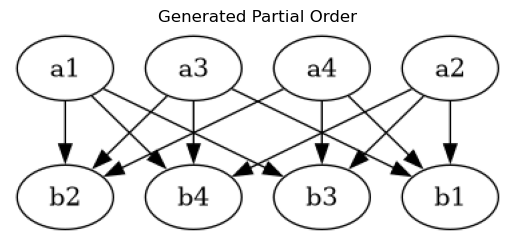

The targeted crown_po partial order h is : [[0 0 0 0 0 1 1 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 1 1 0 1]
 [0 0 0 0 1 1 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]

--- Partial Order Description ---
Number of Nodes: 8
Number of Relationships: 12
Number of Alone Nodes: 0
Alone Nodes: []
Maximum In-Degree: 3
Maximum Out-Degree: 3
Maximum Relationships per Node: 3
Number of Linear Extensions: 720
Depth of Partial Order: 1
---------------------------------

Number of linear extensions found: 720.


In [10]:
############################
# Let's do a demonstration with k=3 => n=6
############################
k=4
items, adj, crown_po= generate_crown_poset(k)
POPlot.visualize_partial_order(BasicUtils.transitive_reduction(crown_po), items,title='Generated Partial Order')
print(f"The targeted crown_po partial order h is : {crown_po}")

StatisticalUtils.description_partial_order(crown_po)

# Enumerate linear extensions
all_exts = BasicUtils.generate_all_linear_extensions(crown_po,items)
print(f"\nNumber of linear extensions found: {len(all_exts)}.")


We first need to find the critical pairs.

In [11]:
critical_pairs = find_critical_pairs(items, crown_po)
print(f"\nCritical pairs: {critical_pairs}")
(f"The length of Critical pairs is: {len(critical_pairs)}")


Critical pairs: [('a1', 'a2'), ('a1', 'a3'), ('a1', 'a4'), ('a1', 'b1'), ('a2', 'a3'), ('a2', 'a4'), ('a2', 'b2'), ('a3', 'a4'), ('a3', 'b3'), ('a4', 'b4'), ('b1', 'b2'), ('b1', 'b3'), ('b1', 'b4'), ('b2', 'b3'), ('b2', 'b4'), ('b3', 'b4')]


'The length of Critical pairs is: 16'

In [12]:
# realizer, size = find_min_realizer_brute_optimized(crown_po, items)
# print(f"Brute force realizer size = {size}")
# for s in realizer:
#     print("  ", s)

In [13]:
realizer, size =  find_min_realizer_via_critical_pairs(crown_po, items)
print(f"Brute force realizer size via critical pairs= {size}")
for s in realizer:
    print("  ", s)

Brute force realizer size via critical pairs= 4
   ['a1', 'a2', 'a3', 'b4', 'a4', 'b1', 'b2', 'b3']
   ['a1', 'a2', 'a4', 'b3', 'a3', 'b1', 'b2', 'b4']
   ['a1', 'a3', 'a4', 'b2', 'a2', 'b1', 'b3', 'b4']
   ['a2', 'a3', 'a4', 'b1', 'a1', 'b2', 'b3', 'b4']


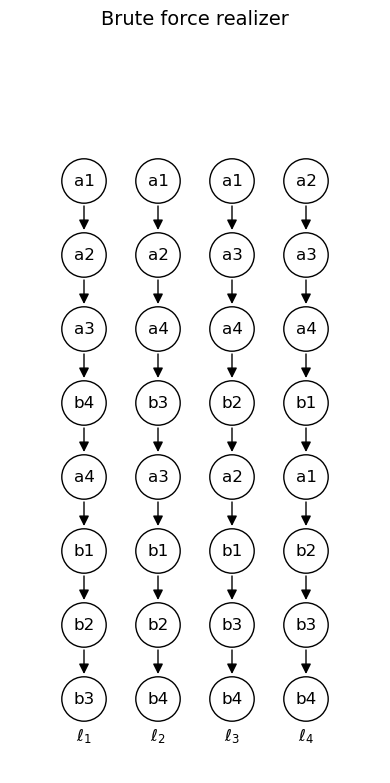

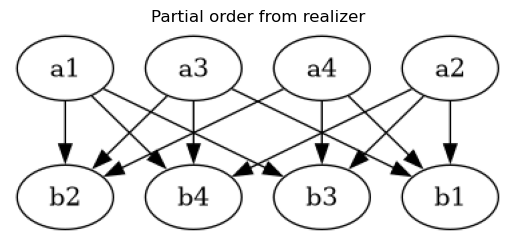

In [14]:
from matplotlib.patches import Circle, FancyArrowPatch
def plot_linear_extensions_vertical(realizer):

    n_orders = len(realizer)
    n_items = len(realizer[0])
    
    # Define parameters for layout.
    gap = 1              # Horizontal gap between columns.
    node_radius = 0.3    # Radius for each circular node.
    top_y = n_items + 1  # Y-coordinate for the top (above the top node).
    
    # Create figure and axis.
    fig, ax = plt.subplots(figsize=(n_orders * gap, n_items + 2))
    
    for order_idx, order in enumerate(realizer):
        x = order_idx * gap  # x-coordinate for the column.
        # Draw each node from top to bottom.
        for pos, item in enumerate(order):
            # y-coordinate: top node at y = n_items, bottom node at y = 1.
            y = n_items - pos
            # Draw circle.
            circle = Circle((x, y), radius=node_radius, edgecolor='black',
                            facecolor='white', zorder=2)
            ax.add_patch(circle)
            # Annotate node with the item label.
            ax.text(x, y, str(item), fontsize=12, ha='center', va='center', zorder=3)
            
            # Draw arrow from current node to next, if not the last node.
            if pos < n_items - 1:
                start = (x, y - node_radius)
                end = (x, y - 1 + node_radius)
                arrow = FancyArrowPatch(start, end, arrowstyle='-|>', mutation_scale=15,
                                        color='black', linewidth=1, zorder=1)
                ax.add_patch(arrow)
        
        # Label the linear extension below the nodes.
        ax.text(x, 0.5, f"$\\ell_{{{order_idx + 1}}}$", fontsize=12, ha='center', va='center')
    
    # Set axis limits and remove axes.
    ax.set_xlim(-1, (n_orders - 1) * gap + 1)
    ax.set_ylim(0, n_items + 2)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.title("Brute force realizer", fontsize=14)
    plt.tight_layout()
    plt.show()



plot_linear_extensions_vertical(realizer)

H = realizer_to_partial_order_matrix(realizer, items)
POPlot.visualize_partial_order(H, items, title="Partial order from realizer")

## 4. The MCMC alogrithm for crown partial orders
In this section, we focus on an 8-element crown partial order from section 2 and demonstrate our MCMC sampling procedure for total orders derived from it. We then use these sampled total orders to reconstruct partial orders and examine the impact of the hyperparameter $k$.
- We begin with an 8-element crown poset and generate total orders consistent with this partial order. These total orders serve as our observed data.
- Given the sampled total orders, we apply an MCMC procedure to infer the underlying partial order.
- For a crown poset with $n = 8$, the natural choice of $k$ is typically $n/2$. However, we do not hard-code this value. Instead, we explore different approaches:
    1. We run separate MCMC chains with $k = 2$ and $k = n/2$. We then compare the inferred partial orders (specifically, the average of $\hat{h}^{k}_{i,j}$ to see if the results are comparable. We expect the average $h_{i,j}$ for each chain to lie near the diagonal $y = x$, indicating a consistent partial order.
    $$ \hat{h}^{k}_{i,j} = \frac{1}{T} \sum_{t=1}^{T} h_{i,j}^{(k),(t)} $$
    2. Reversible Jump: We allow $k$ to vary within the MCMC via reversible jump moves. Given the prior knowledge that $k = n/2$ for a crown poset, we anticipate that the posterior distribution of $k$ will concentrate around 3 or 4. Likewise, we expect the posterior distribution of $h_{i,j}$ (the adjacency in the partial order) to be near the diagonal $y = x$, reflecting a faithful reconstruction of the crown structure.

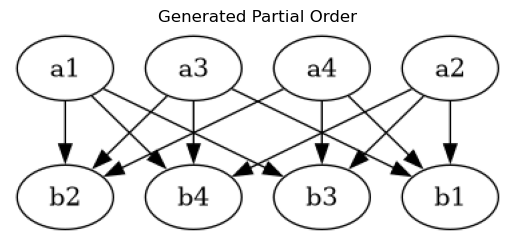

The targeted partial order h is : [[0 0 0 0 0 1 1 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 1 1 0 1]
 [0 0 0 0 1 1 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]

--- Partial Order Description ---
Number of Nodes: 8
Number of Relationships: 12
Number of Alone Nodes: 0
Alone Nodes: []
Maximum In-Degree: 3
Maximum Out-Degree: 3
Maximum Relationships per Node: 3
Number of Linear Extensions: 720
Depth of Partial Order: 1
---------------------------------


In [15]:
h_true= BasicUtils.transitive_reduction(crown_po)
POPlot.visualize_partial_order(h_true, items,title='Generated Partial Order')
print(f"The targeted partial order h is : {h_true}")
StatisticalUtils.description_partial_order(h_true)

In [16]:
n=len(crown_po[0])
N=100
K1=2
K2=int(n//2) 
rho_prior = config["prior"]["rho_prior"]
noise_option = config["noise"]["noise_option"]
mallow_ua = config["prior"]["mallow_ua"]
items = list(range(n))
rho_true=beta.rvs(1,rho_prior)
print("The generated rho true is:")
print(rho_true)



The generated rho true is:
0.6057635342590901


In [17]:
p = config["covariates"]["p"]  # Number of covariates
beta_true = config["covariates"]["beta_true"]   # True regression coefficients
X = np.random.randn(p, n) 
alpha = X.T @ beta_true  
print("\n The covariates effects (alpha):")
print(alpha)



 The covariates effects (alpha):
[-0.21434034  0.10732787  0.33007844 -0.34406061  0.13075088  0.38232052
 -0.01472742 -0.45221565]


### a. Generate the distribution  of the list withthe queue jump error:

In [18]:
items = list(range(n))
item_to_index = {item: idx for idx, item in enumerate(items)}
subsets = GenerationUtils.generate_subsets(N, n)
h_tc=BasicUtils.transitive_closure(h_true)
noise_beta_prior = config["prior"]["noise_beta_prior"] 
prob_noise = StatisticalUtils.rPprior(noise_beta_prior)
prob_noise_true=prob_noise 
total_orders = []
for choice_set in subsets:
    if noise_option == "queue_jump":
        y_generated = StatisticalUtils.generate_total_order_for_choice_set_with_queue_jump(choice_set, items,h_tc, prob_noise)

    elif noise_option == "mallows_noise":
        y_generated = StatisticalUtils.generate_total_order_for_choice_set_with_mallow_noise(choice_set,items, h_tc,  mallow_ua)
    total_orders.append(y_generated)

print(f'The probability of noise is: {prob_noise_true}')

The probability of noise is: 0.027568305185147197


### b. MCMC Simulation for different K

In [19]:
num_iterations = config["mcmc"]["num_iterations"]
mcmc_pt = [
    config["mcmc"]["update_probabilities"]["rho"],
    config["mcmc"]["update_probabilities"]["noise"],
    config["mcmc"]["update_probabilities"]["U"]
]
dr = config["rho"]["dr"]

noise_option = config["noise"]["noise_option"]
sigma_mallow = config["noise"]["sigma_mallow"]

noise_beta_prior = config["prior"]["noise_beta_prior"]
mallow_ua = config["prior"]["mallow_ua"]

mallow_theta_true=1
noise_beta_prior = config["prior"]["noise_beta_prior"]
mallow_ua = config["prior"]["mallow_ua"]
alpha = X.T @ beta_true  

 
mcmc_results1 = mcmc_partial_order(
    total_orders,
    subsets,
    num_iterations,
    K1,
    dr,
    sigma_mallow,
    noise_option,
    mcmc_pt,
    rho_prior, 
    noise_beta_prior,
    mallow_ua,
    alpha 
)

print(f"MCMC 1 for k={K1} run complete")

mcmc_results2 = mcmc_partial_order(
    total_orders,
    subsets,
    num_iterations,
    K2,
    dr,
    sigma_mallow,
    noise_option,
    mcmc_pt,
    rho_prior, 
    noise_beta_prior,
    mallow_ua,
    alpha 
)

print(f"MCMC 2 k={K2} run complete")



Iteration 100000/1000000 - Accept Rate: 29.28%
Iteration 200000/1000000 - Accept Rate: 29.32%
Iteration 300000/1000000 - Accept Rate: 29.43%
Iteration 400000/1000000 - Accept Rate: 29.33%
Iteration 500000/1000000 - Accept Rate: 29.23%
Iteration 600000/1000000 - Accept Rate: 29.14%
Iteration 700000/1000000 - Accept Rate: 29.13%
Iteration 800000/1000000 - Accept Rate: 29.13%
Iteration 900000/1000000 - Accept Rate: 29.06%
Iteration 1000000/1000000 - Accept Rate: 29.03%

Overall Acceptance Rate after 1000000 iterations: 29.03%
MCMC 1 for k=2 run complete
Iteration 100000/1000000 - Accept Rate: 26.14%
Iteration 200000/1000000 - Accept Rate: 26.02%
Iteration 300000/1000000 - Accept Rate: 26.03%
Iteration 400000/1000000 - Accept Rate: 26.08%
Iteration 500000/1000000 - Accept Rate: 26.01%
Iteration 600000/1000000 - Accept Rate: 26.03%
Iteration 700000/1000000 - Accept Rate: 26.06%
Iteration 800000/1000000 - Accept Rate: 26.03%
Iteration 900000/1000000 - Accept Rate: 26.01%
Iteration 1000000/10

#### The MCMC result analysis 

Excluding 70000 burn-in iterations


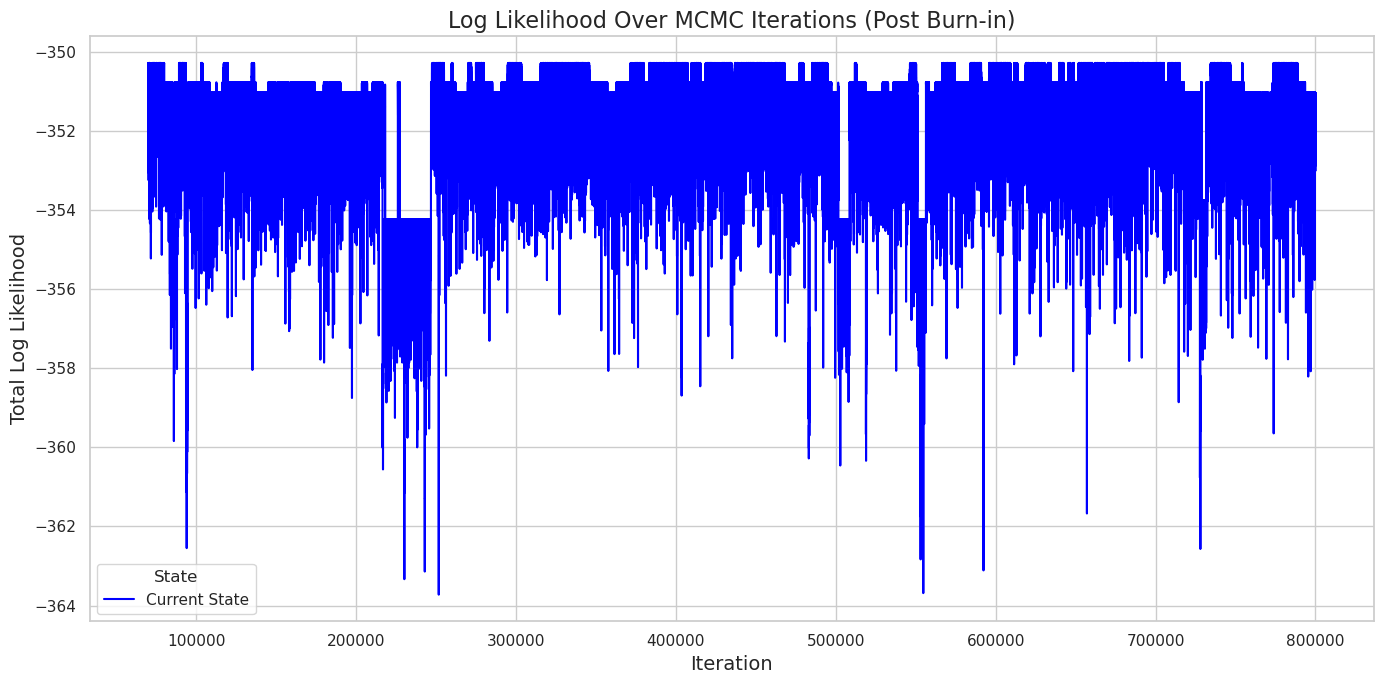

Excluding 50000 burn-in iterations


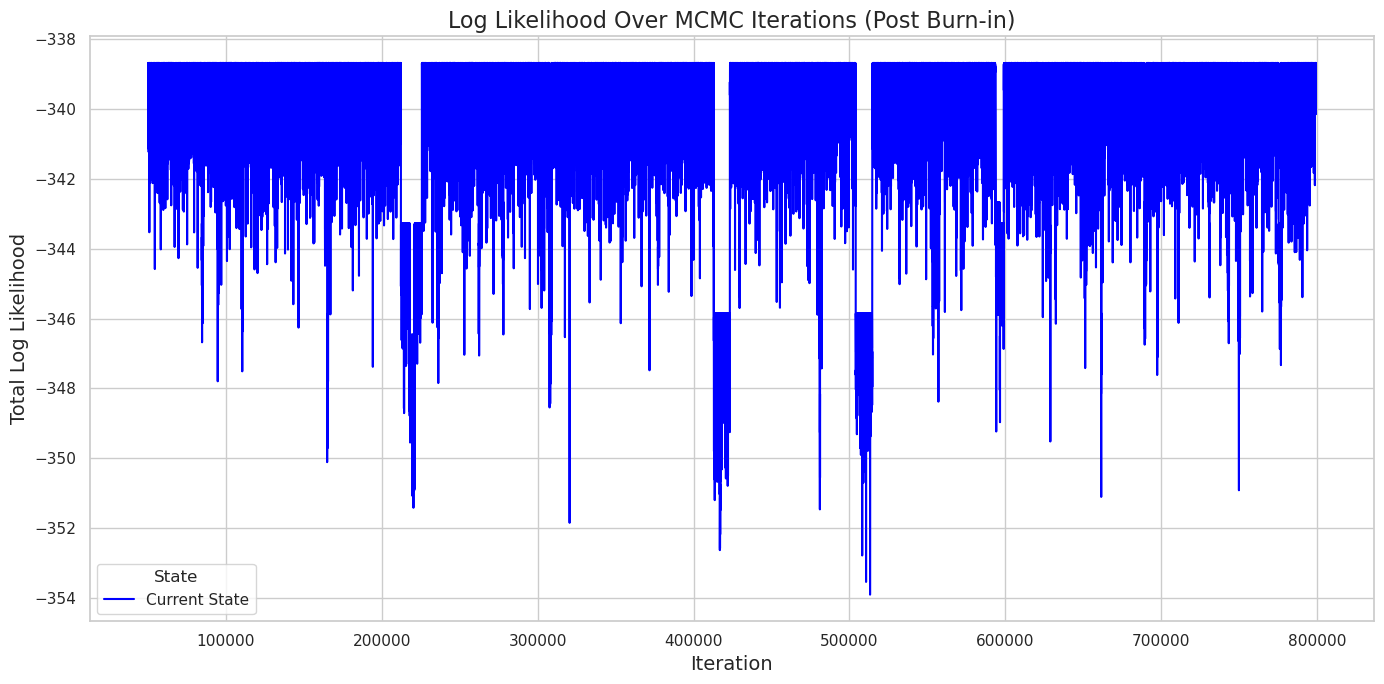

In [20]:
# Get log likelihood values from MCMC results
log_likelihood_currents1 = mcmc_results1.get('log_likelihood_currents', [])
log_likelihood_currents2 = mcmc_results2.get('log_likelihood_currents', [])

#POPlot.plot_log_likelihood(log_likelihood_currents1)
POPlot.plot_log_likelihood(log_likelihood_currents1,burn_in=70000)
POPlot.plot_log_likelihood(log_likelihood_currents2,burn_in=50000)

Final adjacency (thresholded) for k=2:
Final adjacency (thresholded) for k=4:


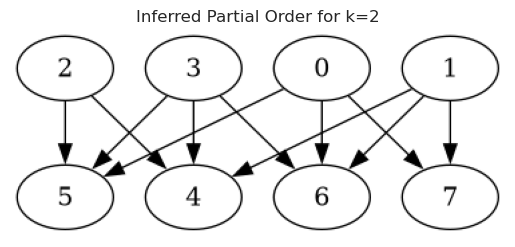

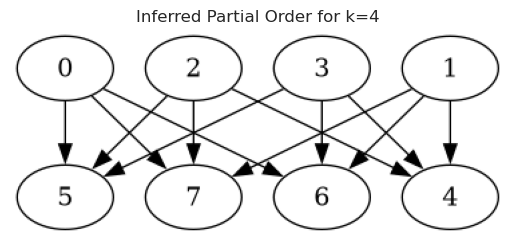

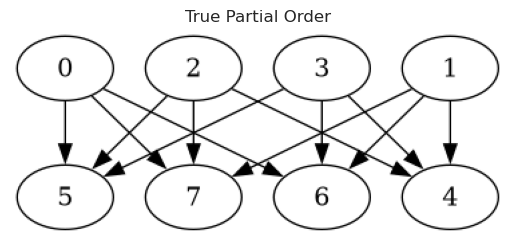

In [21]:
burn_in = int(50000/ 100)  # Convert to integer (1000 instead of 1000.0)
post_burn_in_trace1=mcmc_results1['h_trace'][burn_in:]
h_final1=np.mean(post_burn_in_trace1,axis=0)

threshold=0.5
index_to_item1 = mcmc_results1['index_to_item']
iterations = list(range(1, num_iterations + 1))

h_final_inferred1=BasicUtils.transitive_reduction(h_final1>=threshold).astype(int)


print(f"Final adjacency (thresholded) for k={K1}:")

post_burn_in_trace2=mcmc_results2['h_trace'][burn_in:]
h_final2=np.mean(post_burn_in_trace2,axis=0)

threshold=0.5
index_to_item2 = mcmc_results2['index_to_item']
iterations = list(range(1, num_iterations + 1))

h_final_inferred2=BasicUtils.transitive_reduction(h_final2>=threshold).astype(int)
print(f"Final adjacency (thresholded) for k={K2}:")



# Plot Inferred Partial Order
POPlot.visualize_partial_order(
    final_h=h_final_inferred1,
    Ma_list=items, 
    title=f'Inferred Partial Order for k={K1}',
)
#
# Plot Inferred Partial Order
POPlot.visualize_partial_order(
    final_h=h_final_inferred2,
    Ma_list=items, 
    title=f'Inferred Partial Order for k={K2}',
)

# Plot True Partial Order and Inferred Partial Order
POPlot.visualize_partial_order(
    final_h=BasicUtils.transitive_reduction(h_true),
    Ma_list=items, 
    title='True Partial Order',
)

In [ ]:
realizer1, size1 = find_min_realizer_brute_optimized(h_final_inferred1, items)
print(f"Brute force realizer size for k={K1}: {size1}")
for s in realizer1:
    print("  ", s)


In [ ]:

realizer2, size2 = find_min_realizer_brute_optimized(h_final_inferred2, items)
print(f"Brute force realizer size for k={K2}:{size2}")
for s in realizer2:
    print("  ", s)

We could observe that it is hard to generate the true partial order for a crown poset. This is because the dimension is high and the number of edges is large. In this case which is 16, and there are more total order needed to include the linear extensions that are required to cover the critical pairs.

High‐Dimensional Crowns Are Hard to Reconstruct

Crowns have many incomparable (critical) pairs. To represent all those incomparabilities accurately, one typically needs a larger realizer. However, with noisy or limited data, an MCMC approach might gravitate toward a lower‐dimensional partial order that “explains” the data sufficiently (especially if there is no strong penalty for underestimating the dimension).


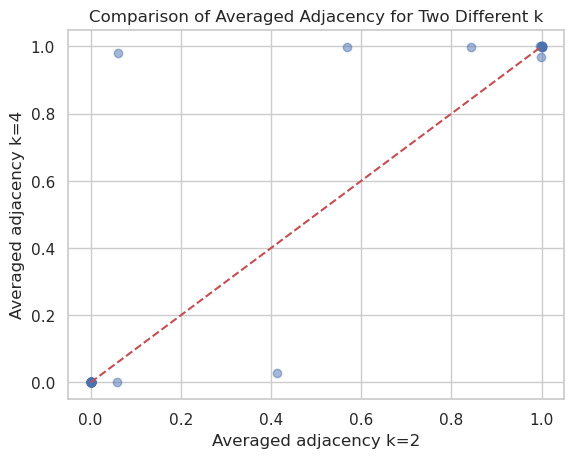

In [23]:
plt.figure()
plt.scatter(h_final1.flatten(), h_final2.flatten(), alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # y = x line
plt.xlabel(f"Averaged adjacency k={K1}")
plt.ylabel(f"Averaged adjacency k={K2}")
plt.title("Comparison of Averaged Adjacency for Two Different k")
plt.show()


The scatter plot of the two averaged adjacency matrices lies very close to the diagonal, indicating that the inferred partial orders for k=2 and k=4 are almost the same. In other words, once the MCMC converged, both runs yielded essentially the same adjacency structure in spite of different latent dimensions.

#### The MCMC posterior plot 
Note that the rho plot below is not meaningful since the rho_true is not used in the calculation of the true dimension. Crown graph have a fixed structure 

[INFO] Saved MCMC parameter plots to 'mcmc_inferred_result.pdf'


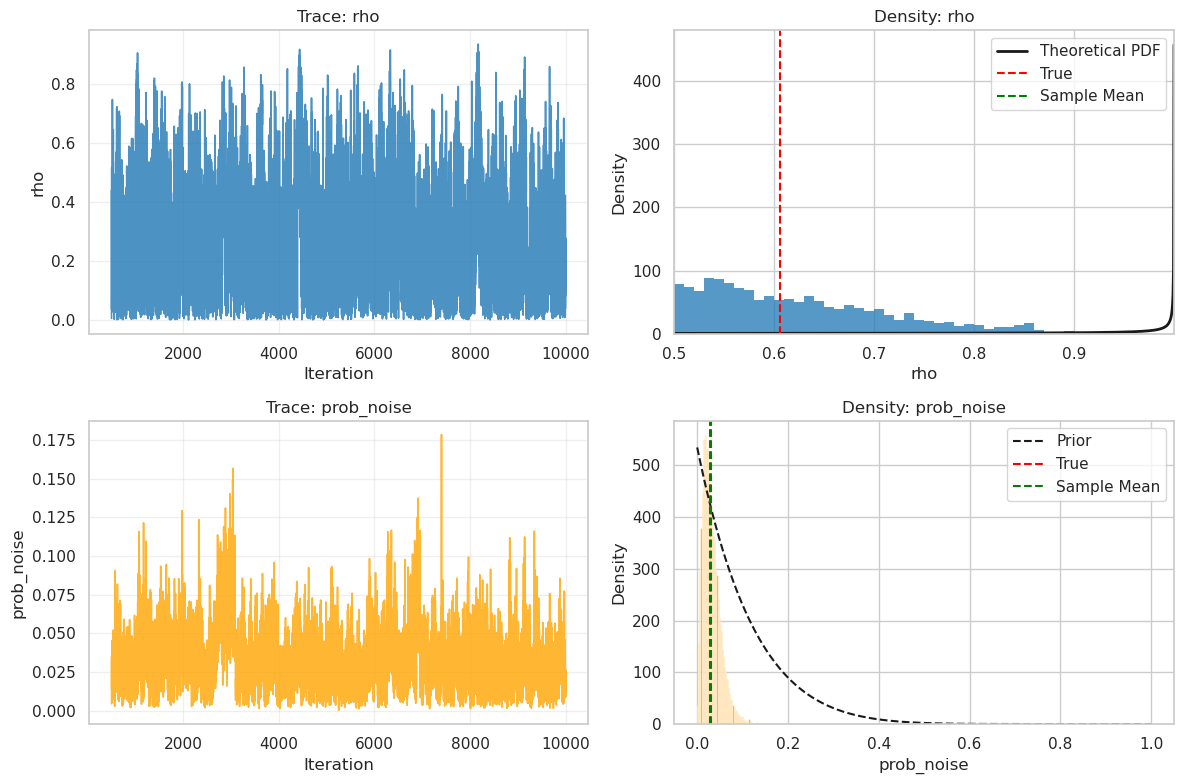

[INFO] Saved MCMC parameter plots to 'mcmc_inferred_result.pdf'


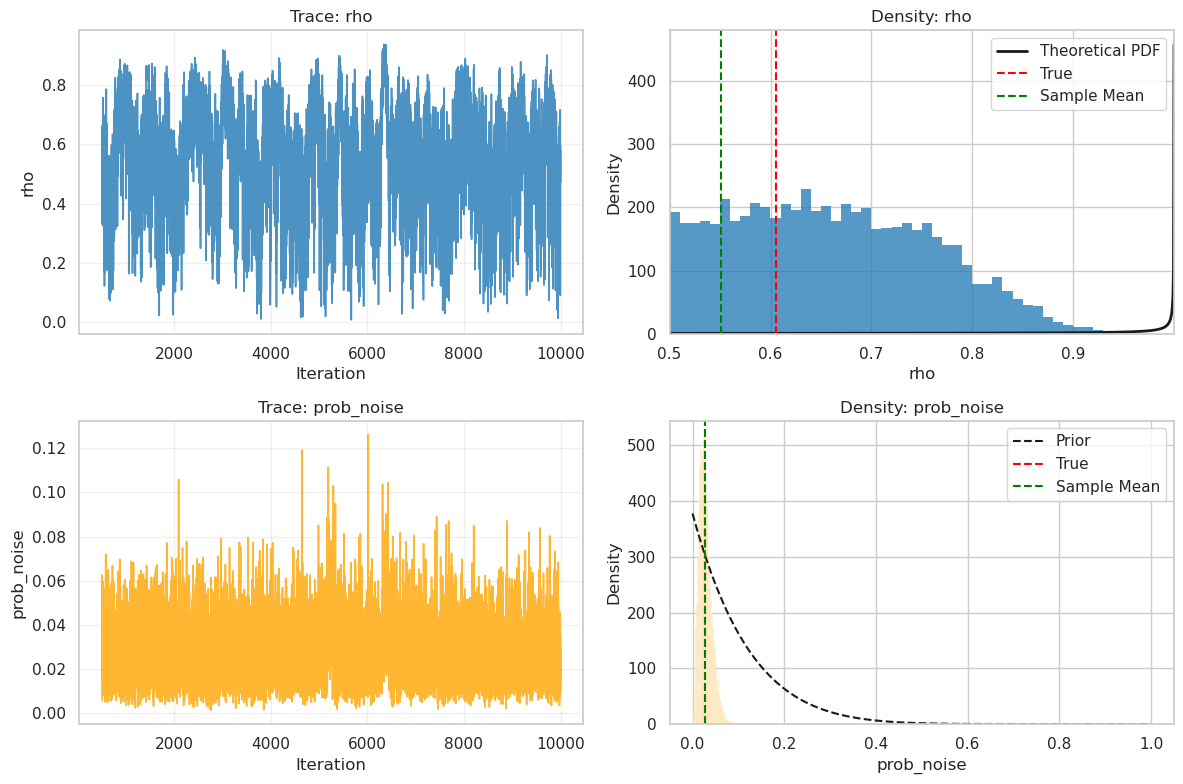

In [24]:
true_param = {
    "rho_true": rho_true,
    "prob_noise_true": prob_noise_true    

}


POPlot.plot_mcmc_inferred_variables(
    mcmc_results1,
    true_param,
    config,
    burn_in=burn_in,  # optional
    output_filename="mcmc_inferred_result.pdf"
)

POPlot.plot_mcmc_inferred_variables(
    mcmc_results2,
    true_param,
    config,
    burn_in=burn_in,  # optional
    output_filename="mcmc_inferred_result.pdf"
)

In short, both MCMC runs converge to very similar partial orders, and each yields a realizer of size 2—even though we know a crown poset of this size would normally require a higher dimension. This discrepancy highlights that (1) crown posets are comparatively difficult to infer, and (2) simply increasing the latent dimension parameter k in the MCMC does not guarantee that the true high‐dimensional partial order will be recovered, especially if the data or run settings do not strongly constrain the model.

### c. MCMC Simulation for the reversible jump of K 

In [25]:
K_prior=config["prior"]["K_prior"]
K_true=int(n//2)

num_iterations=config["mcmc"]["num_iterations"]
mcmc_pt= [
    config["mcmc"]["update_probabilities"]["rho"],
    config["mcmc"]["update_probabilities"]["noise"],
    config["mcmc"]["update_probabilities"]["U"],
    config["mcmc"]["update_probabilities"]["K"]
]

mcmc_results = mcmc_partial_order_k(
    total_orders,
    subsets,
    num_iterations,
    dr,
    sigma_mallow,
    noise_option,
    mcmc_pt,
    rho_prior, 
    noise_beta_prior,
    mallow_ua,
    alpha,
    K_prior
)

print("MCMC 3 k={K3} run complete")




Iteration 100000/1000000 - Accept Rate: 28.78%
Iteration 200000/1000000 - Accept Rate: 28.72%
Iteration 300000/1000000 - Accept Rate: 28.73%
Iteration 400000/1000000 - Accept Rate: 28.69%
Iteration 500000/1000000 - Accept Rate: 28.69%
Iteration 600000/1000000 - Accept Rate: 28.72%
Iteration 700000/1000000 - Accept Rate: 28.69%
Iteration 800000/1000000 - Accept Rate: 28.70%
Iteration 900000/1000000 - Accept Rate: 28.72%
Iteration 1000000/1000000 - Accept Rate: 28.73%

Overall Acceptance Rate after 1000000 iterations: 28.73%
MCMC 3 k={K3} run complete


Excluding 10000 burn-in iterations


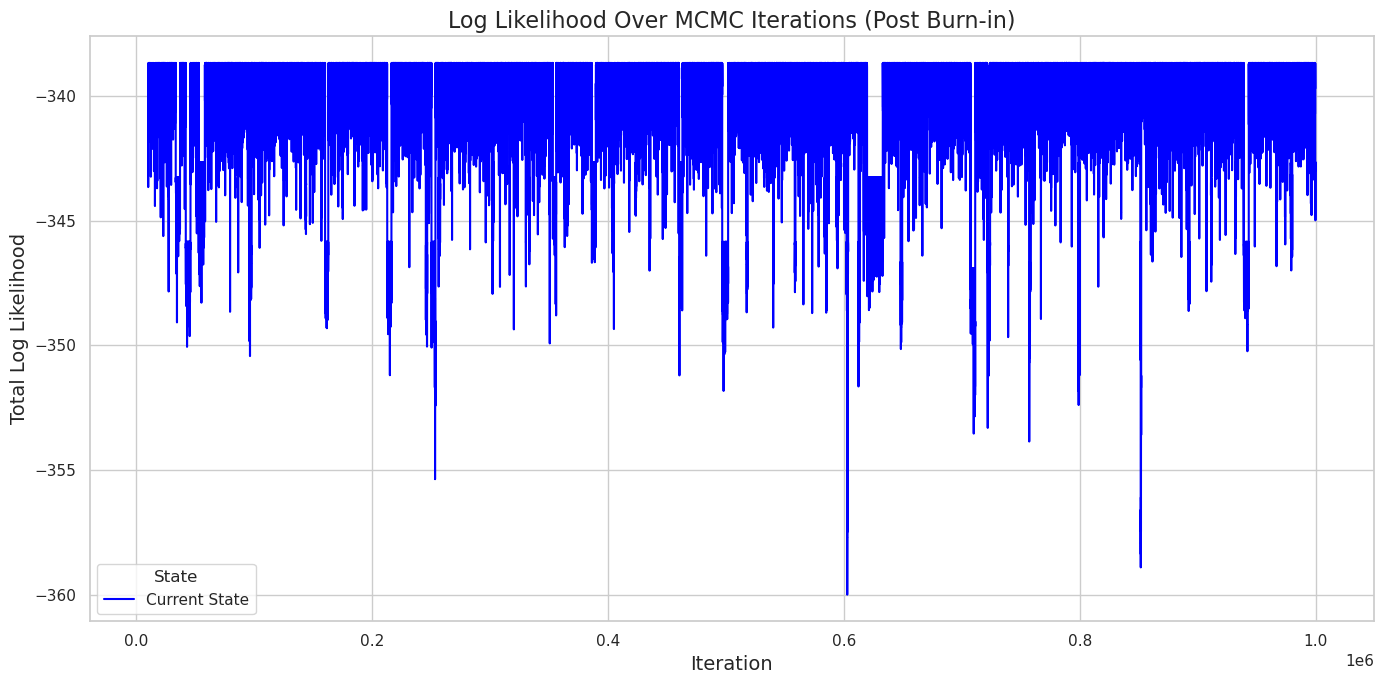

In [26]:
# Get log likelihood values from MCMC results
log_likelihood_currents = mcmc_results.get('log_likelihood_currents', [])

#PO_plot.plot_log_likelihood(log_likelihood_currents1)
POPlot.plot_log_likelihood(log_likelihood_currents,burn_in=10000)

Final adjacency (thresholded) for reversible jump k :


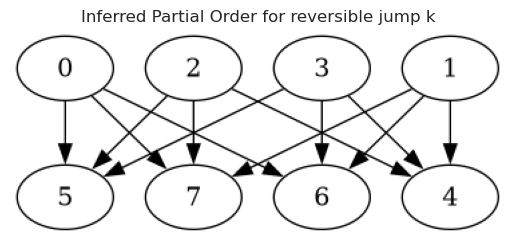

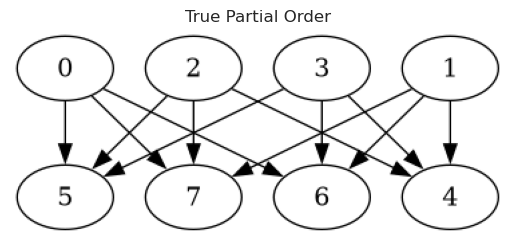

In [27]:
burn_in = int(10000/ 100)  # Convert to integer (1000 instead of 1000.0)
post_burn_in_trace=mcmc_results['h_trace'][burn_in:]
h_final=np.mean(post_burn_in_trace,axis=0)

threshold=0.5
index_to_item= mcmc_results['index_to_item']
iterations = list(range(1, num_iterations + 1))

h_final_inferred=BasicUtils.transitive_reduction(h_final>=threshold).astype(int)


print(f"Final adjacency (thresholded) for reversible jump k :")




# Plot Inferred Partial Order
POPlot.visualize_partial_order(
    final_h=h_final_inferred,
    Ma_list=items, 
    title=f'Inferred Partial Order for reversible jump k',
)


# Plot True Partial Order and Inferred Partial Order
POPlot.visualize_partial_order(
    final_h=BasicUtils.transitive_reduction(h_true),
    Ma_list=items, 
    title='True Partial Order',
)

The reversible jump MCMC gives a similar result as what we have obtained by setting k=2.

In [ ]:
realizer, size= find_min_realizer_brute_optimized(h_final_inferred, items)
print(f"Brute force realizer size for k reversible jump : {size1}")
for s in realizer1:
    print("  ", s)

[INFO] Saved MCMC parameter plots to 'mcmc_inferred_result.pdf'


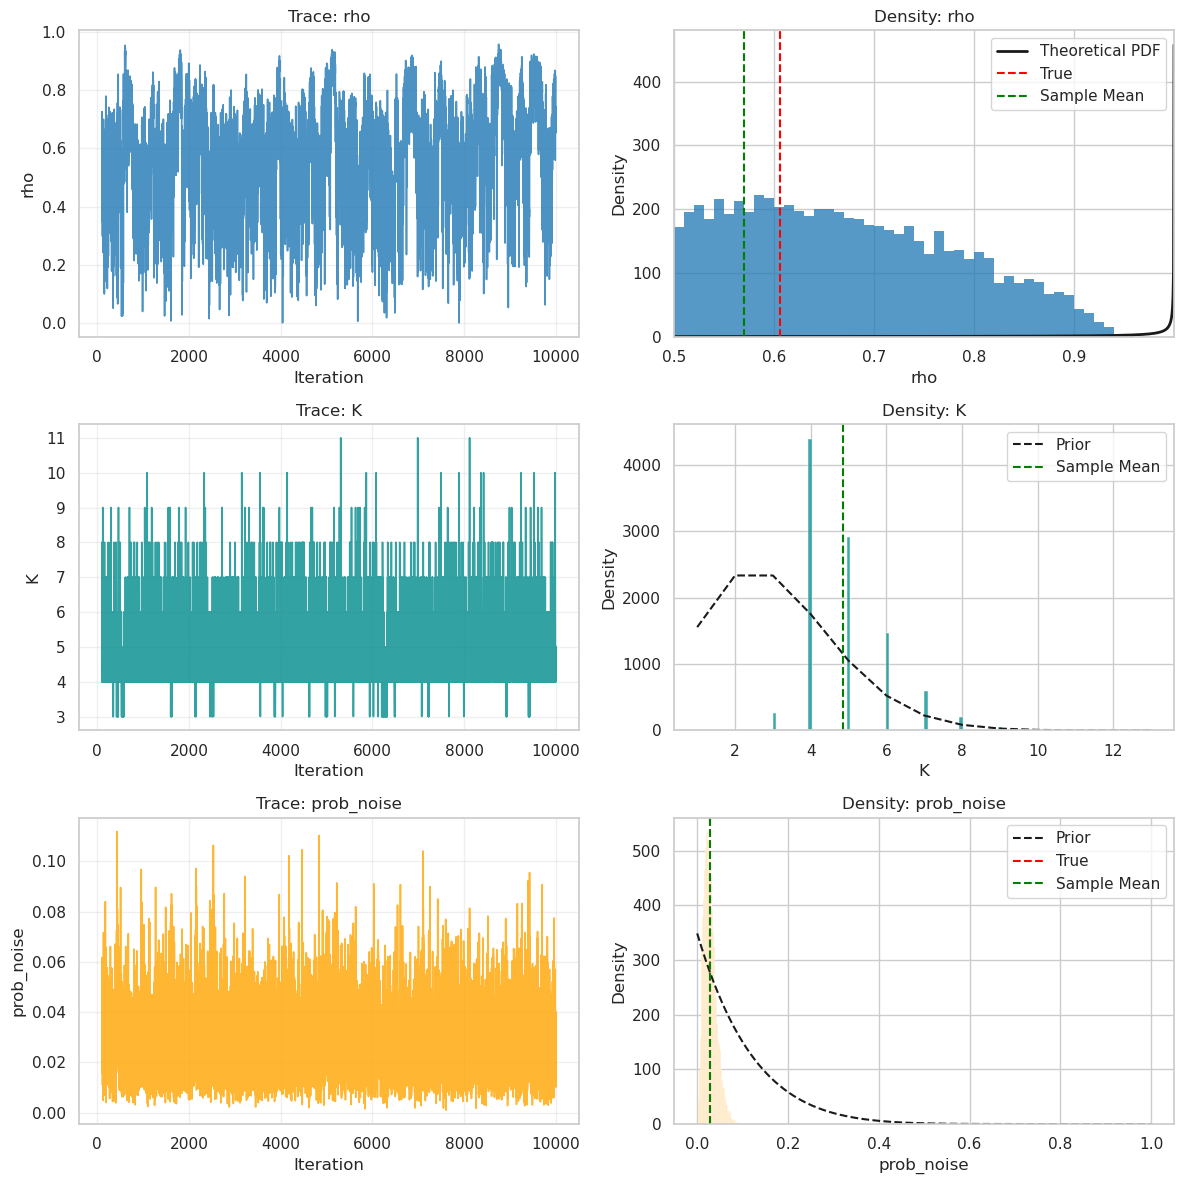

In [29]:

POPlot.plot_mcmc_inferred_variables(
    mcmc_results,
    true_param,
    config,
    burn_in=burn_in,  # optional
    output_filename="mcmc_inferred_result.pdf"
)